In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from fredapi import Fred

fred = Fred(api_key="388e4633f23c88b89679b89794f572ed")
from tqdm import tqdm

import warnings

warnings.filterwarnings("ignore")

# Initial analysis


In [2]:
consumerloans_series = fred.get_series("CCLACBW027SBOG")
consumerloans_df = pd.DataFrame(consumerloans_series, columns=["consumerloans"])
consumerloans_df.index.name = "date"
# first date is 2000-06-28, last is 2024-04-10

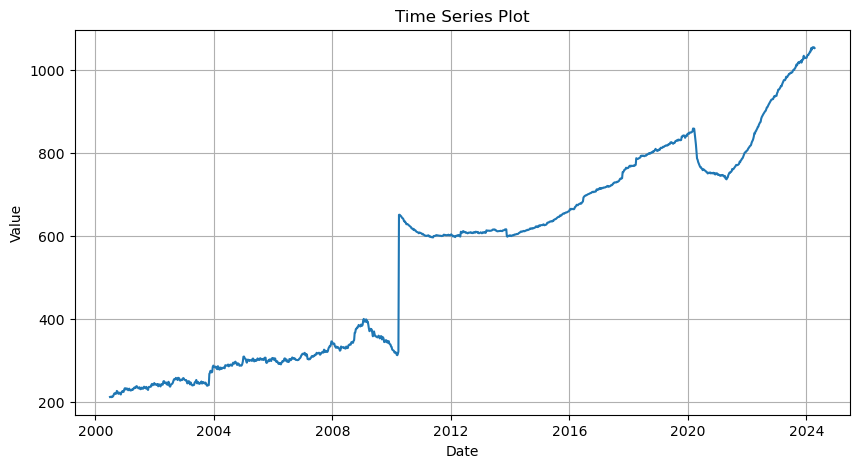

In [3]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans_df)
plt.title("Time Series Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.grid(True)
plt.show()

## Adjusting for jumps


Jumps noted by fedreserve in billions

January 5, 2022 - 1.7
October 14, 2020 - 1.5
October 16, 2019 - 8.1
April 4, 2018 - 14.1
October 18, 2017 - 13.8
November 20, 2013 - -16.2
March 13, 2013 - 5.2
May 2, 2012 - 9.0
March 31, 2010 - 334.9
October 1, 2008 - 15.6
July 4, 2007 - 2.6
June 21, 2006 - -7.2
October 5, 2005 - -2.4
February 9, 2005 - -1.7
December 29, 2004 - 12.0
April 21, 2004 - -1.8
December 17, 2003 - 7.4
November 5, 2003 - 22.4
July 2, 2003 - 0.7


In [4]:
# you could either add jump amounts to prior dates or subtract from following dates to normalize. I will add to prior dates.
# Creating the jump dictionary
jumps = {
    "date": [
        "January 5, 2022",
        "October 14, 2020",
        "October 16, 2019",
        "April 4, 2018",
        "October 18, 2017",
        "November 20, 2013",
        "March 13, 2013",
        "May 2, 2012",
        "March 31, 2010",
        "October 1, 2008",
        "July 4, 2007",
        "June 21, 2006",
        "October 5, 2005",
        "February 9, 2005",
        "December 29, 2004",
        "April 21, 2004",
        "December 17, 2003",
        "November 5, 2003",
        "July 2, 2003",
    ],
    "value": [
        1.7,
        1.5,
        8.1,
        14.1,
        13.8,
        -16.2,
        5.2,
        9.0,
        334.9,
        15.6,
        2.6,
        -7.2,
        -2.4,
        -1.7,
        12.0,
        -1.8,
        7.4,
        22.4,
        0.7,
    ],
}

# Convert date strings to datetime objects
jump_df = pd.DataFrame(jumps)
jump_df["date"] = pd.to_datetime(jump_df["date"])
jump_df = jump_df.set_index("date")

consumerloans_clean = consumerloans_df.merge(
    jump_df, how="left", left_index=True, right_index=True
)
consumerloans_clean.rename(columns={"value": "jump"}, inplace=True)
consumerloans_clean["jump"] = consumerloans_clean["jump"].fillna(0)

# Adjusting jump sum for inflation with Gross domestic purchases (chain-type price index).
grossdomesticpurchases_series = fred.get_series("B712RG3Q086SBEA")
grossdomesticpurchases_df = pd.DataFrame(
    grossdomesticpurchases_series, columns=["grossdomesticpurchases"]
)
grossdomesticpurchases_df.rename_axis(index="date", inplace=True)

# Creating a DataFrame to store the cumulative jumps
cumulative_jumps = pd.DataFrame(index=consumerloans_clean.index)
cumulative_jumps["jump"] = consumerloans_clean["jump"]

# Performing an asof merge
merged_df = pd.merge_asof(
    cumulative_jumps,
    grossdomesticpurchases_df,
    left_index=True,
    right_index=True,
    direction="backward",
)  # 'backward' to take the most recent past value

# Rename the column to 'gdp_idx'
merged_df.rename(columns={"grossdomesticpurchases": "gdp_idx"}, inplace=True)

# Calculate the cumulative jumps
cumulative_jumps = merged_df.reset_index()
cumulative_jumps["cum_jump"] = 0

jump_idx = cumulative_jumps[cumulative_jumps.jump != 0].index
cumulative_jumps["cum_jump"] = cumulative_jumps.cum_jump.astype(float)
for i in jump_idx:
    denominators = cumulative_jumps.gdp_idx / cumulative_jumps.gdp_idx[i]
    cumulative_jumps.loc[: i - 1, "cum_jump"] += (
        cumulative_jumps.jump[i] * denominators[:i]
    )
    # print(max(cumulative_jumps.loc[:i, 'cum_jump'].index))
    # print(max((cumulative_jumps.jump[i] * denominators[: (i + 1)]).index))

consumerloans_clean["consumerloans"] += cumulative_jumps.set_index("date").cum_jump

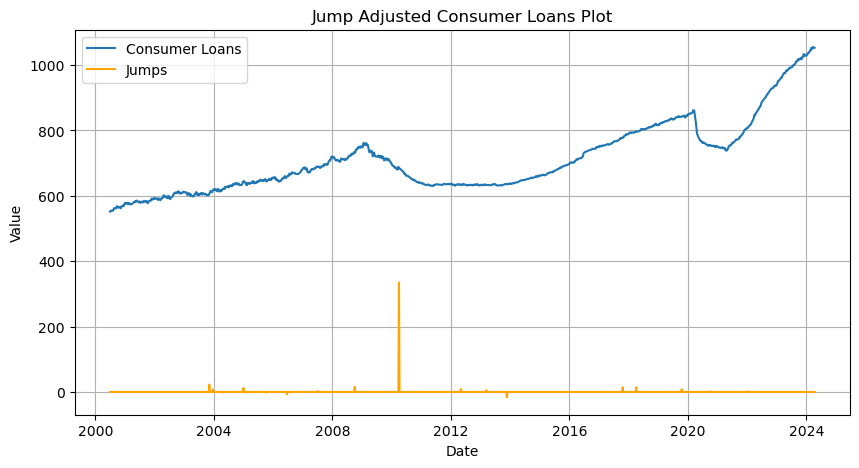

In [5]:
# Plotting the time series
plt.figure(figsize=(10, 5))
plt.plot(consumerloans_clean["consumerloans"], label="Consumer Loans")
plt.plot(consumerloans_clean["jump"], label="Jumps", color="orange")
plt.title("Jump Adjusted Consumer Loans Plot")
plt.xlabel("Date")
plt.ylabel("Value")
plt.legend()
plt.grid(True)
plt.show()

## testing if variance of week-on-week difference changed after march 31, 2010


In [6]:
# Unlike Bartlett's test, which also tests for equal variances but is sensitive to departures from normality, Levene’s test is more robust against non-normal distributions.
from scipy.stats import levene

# Specify the cut-off date
cut_off_date = pd.Timestamp("2010-03-31")

# Split the data into two segments
before = consumerloans_clean[consumerloans_clean.index < cut_off_date]
after = consumerloans_clean[consumerloans_clean.index >= cut_off_date]

# Calculate week-on-week differences
diff_before = before["consumerloans"].diff().dropna()
diff_after = after["consumerloans"].diff().dropna()

# Calculate variances
var_before = diff_before.var()
var_after = diff_after.var()

# Statistical test for equality of variance
stat, p_value = levene(diff_before, diff_after)

print(f"Variance Before: {var_before}")
print(f"Variance After: {var_after}")
print(f"Levene's test statistic: {stat}, p-value: {p_value}")

Variance Before: 8.91211618316357
Variance After: 4.931796978640383
Levene's test statistic: 65.56951319183122, p-value: 1.3315025458446714e-15


For some reason, there is significant difference before and after March 31, 2010. Assume this is because more things are accounted for in reporting after.
Will use variance after this date when finding variance of week-on-week difference.


# Forecasting


## Testing for unit root with ADF


In [7]:
from statsmodels.tsa.stattools import adfuller

# Apply the Augmented Dickey-Fuller test
result = adfuller(consumerloans_clean["consumerloans"])

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: 0.454560
p-value: 0.983425
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


It isnt stationary, so differencing is needed.


In [8]:
consumerloans_clean["consumerloans_diff"] = consumerloans_clean["consumerloans"].diff()

cons_loans_diff = consumerloans_clean["consumerloans_diff"].dropna()

# Apply the Augmented Dickey-Fuller test
result = adfuller(cons_loans_diff)

print("ADF Statistic: %f" % result[0])
print("p-value: %f" % result[1])
print("Critical Values:")
for key, value in result[4].items():
    print("\t%s: %.3f" % (key, value))

ADF Statistic: -4.208595
p-value: 0.000637
Critical Values:
	1%: -3.436
	5%: -2.864
	10%: -2.568


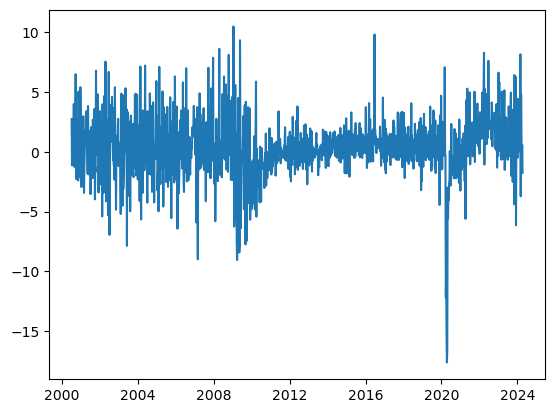

In [10]:
plt.plot(consumerloans_clean.consumerloans.diff())

Differencing once worked.


## Checking different p and q for ARMA model


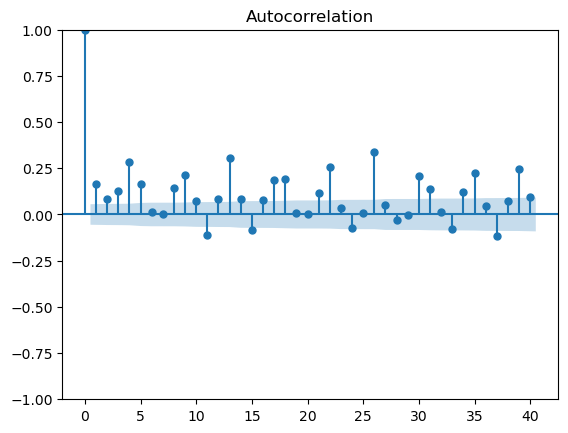

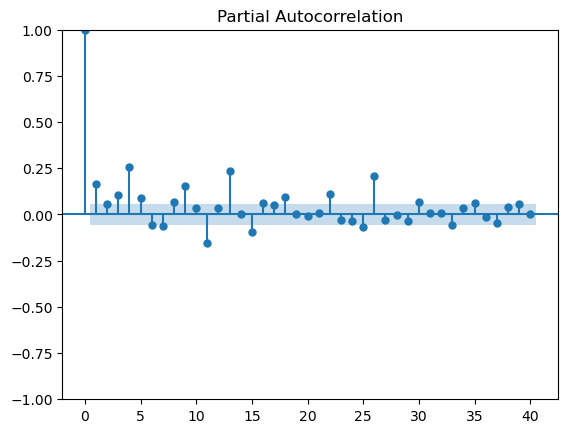

In [11]:
from statsmodels.tsa.stattools import acf, pacf

# Plot ACF and PACF
sm.graphics.tsa.plot_acf(cons_loans_diff, lags=40)
sm.graphics.tsa.plot_pacf(cons_loans_diff, lags=40)
plt.show()

I don't see much from ACF or PCF, so I will just grid search for p and q based on AIC.


In [12]:
pd.DataFrame(cons_loans_diff)

,consumerloans_diff
date,
2000-07-05,2.734375
2000-07-12,-1.136500
2000-07-19,1.662400
2000-07-26,-0.765400
2000-08-02,0.771100
...,...
2024-03-13,4.813500
2024-03-20,1.165700
2024-03-27,-0.762400


In [13]:
from statsmodels.tsa.arima.model import ARIMA

max_lag = 7

# Define p and q range
p = q = range(0, max_lag, 1)  # including 20

# DataFrame to store AICs
aic_table = pd.DataFrame(index=p, columns=q)
models = pd.DataFrame(index=p, columns=q)

# Grid search
for i in tqdm(p):
    for j in q:
        # try:
        model = ARIMA(
            consumerloans_clean.consumerloans, order=(i, 1, j)
        )  # Assuming timeseries is stationary
        results = model.fit()
        aic_table.loc[i, j] = results.aic
        models.loc[i, j] = results
        # except Exception as e:
        #     aic_table.loc[i, j] = np.nan
        #     print(f"Failed to fit ARMA({i},{j}): {e}")

# Find the best model
aic_table = aic_table.astype(float)
min_aic = aic_table.min().min()
best_params = aic_table.stack().idxmin()
print(f"Best ARMA model: ARMA{best_params} with AIC: {min_aic}")

# Display the AIC table
# print(aic_table)

# Optional: Highlight the best model directly if using Jupyter Notebook or similar environment
# aic_table.style.applymap(lambda x: 'background-color: yellow' if x == min_aic else '')

  0%|          | 0/7 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:57<00:00,  8.15s/it]

Best ARMA model: ARMA(6, 4) with AIC: 5555.51679888438


In [14]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(consumerloans_clean["consumerloans"], order=(17, 1, 17)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:          consumerloans   No. Observations:                 1242
Model:               ARIMA(17, 1, 17)   Log Likelihood               -2707.407
Date:                Tue, 23 Apr 2024   AIC                           5484.814
Time:                        16:24:47   BIC                           5664.143
Sample:                    06-28-2000   HQIC                          5552.254
                         - 04-10-2024                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5212      0.466      1.117      0.264      -0.393       1.435
ar.L2          0.8237      0.237      3.483      0.000       0.360       1.287
ar.L3         -0.8191      0.349     -2.350      0.019      -1.502      -0.136
ar.L4          0.0006      0.396      0.001      0.999      -0.775       0.777
ar.L5          0.1153      0.061      1.883      0.060      -0.005       0.235
ar.L6          0.0226      0.065      0.349      0.727      -0.105       0.150
ar.L7          0.0908      0.044      2.071      0.038       0.005       0.177
ar.L8          0.1040      0.046      2.267      0.023       0.014       0.194
ar.L9          0.0068      0.058      0.117      0.907      -0.107       0.120
ar.L10         0.0404      0.047      0.866      0.386      -0.051       0.132
ar.L11        -0.2570      0.052     -4.922      0.000      -0.359      -0.155
ar.L12         0.0500      0.106      0.470      0.638      -0.159       0.258
ar.L13         1.0121      0.056     17.995      0.000       0.902       1.122
ar.L14        -0.7368      0.475     -1.550      0.121      -1.668       0.195
ar.L15        -0.5921      0.317     -1.865      0.062      -1.214       0.030
ar.L16         0.6134      0.263      2.331      0.020       0.098       1.129
ar.L17        -0.0640      0.304     -0.210      0.833      -0.661       0.533
ma.L1         -0.4073      0.470     -0.866      0.387      -1.329       0.515
ma.L2         -0.7037      0.195     -3.609      0.000      -1.086      -0.322
ma.L3          0.7733      0.301      2.565      0.010       0.182       1.364
ma.L4         -0.0065      0.384     -0.017      0.987      -0.759       0.746
ma.L5         -0.0545      0.097     -0.564      0.573      -0.244       0.135
ma.L6         -0.0336      0.068     -0.491      0.624      -0.168       0.101
ma.L7         -0.0694      0.067     -1.042      0.297      -0.200       0.061
ma.L8         -0.0662      0.059     -1.117      0.264      -0.182       0.050
ma.L9          0.0075      0.059      0.129      0.898      -0.107       0.123
ma.L10        -0.1114      0.057     -1.958      0.050      -0.223       0.000
ma.L11         0.1763      0.070      2.501      0.012       0.038       0.314
ma.L12         0.0089      0.093      0.096      0.923      -0.173       0.190
ma.L13        -0.8633      0.051    -17.061      0.000      -0.962      -0.764
ma.L14         0.5983      0.411      1.456      0.145      -0.207       1.403
ma.L15         0.3712      0.249      1.489      0.136      -0.117       0.860
ma.L16        -0.4205      0.187     -2.249      0.024      -0.787      -0.054
ma.L17         0.1377      0.219      0.628      0.530      -0.292       0.567
sigma2         4.5589      0.128     35.666      0.000       4.308       4.809
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):              1415.01
Prob(Q):                              0.98   Prob(JB):                 

<AxesSubplot: xlabel='date'>

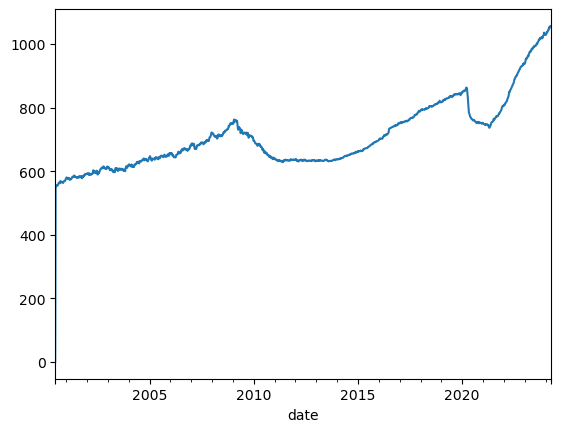

In [15]:
models.loc[best_params].fittedvalues.plot()

## Plotting to see what ARIMA model looks like


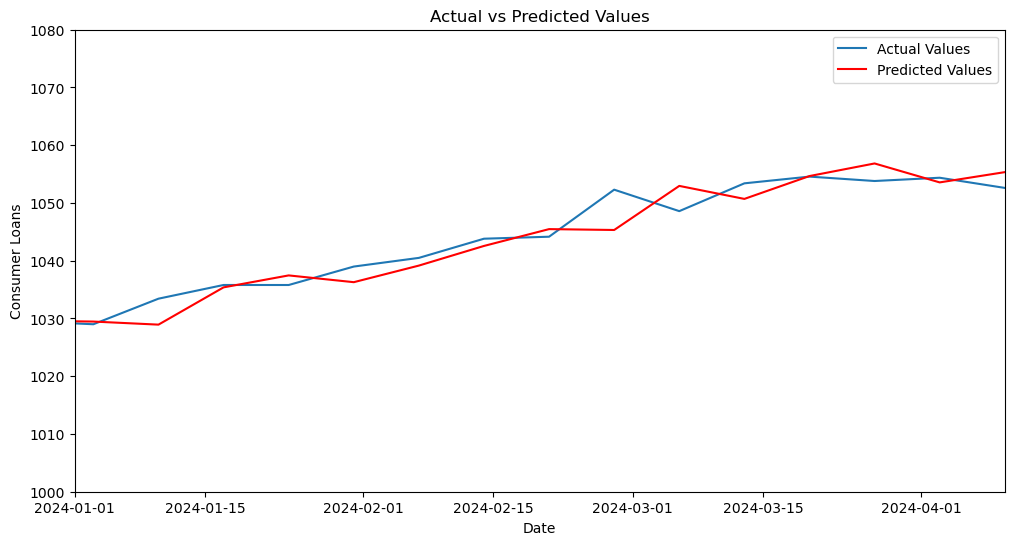

In [16]:
import matplotlib.dates as mdates

# Get the in-sample predictions
model = models.loc[best_params]
predictions = model.predict(
    start=model.fittedvalues.index[0], end=model.fittedvalues.index[-1], dynamic=False
)
actual = consumerloans_clean["consumerloans"][
    1:
]  # adjust indexing based on differencing (d=1)

start_date = pd.to_datetime("2024-01-01")
end_date = pd.to_datetime("2024-04-10")

# Plotting the actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(actual.index, actual, label="Actual Values")
plt.plot(predictions.index, predictions, color="red", label="Predicted Values")
plt.title("Actual vs Predicted Values")
plt.xlabel("Date")
plt.ylabel("Consumer Loans")
plt.gca().set_xlim([start_date, end_date])
plt.ylim(1000, 1080)
plt.legend()
plt.show()

In [17]:
# Get one-step-ahead forecast
one_step_forecast = model.get_prediction(start=end_date, end=end_date)
forecast_mean = one_step_forecast.predicted_mean
forecast_conf_int = one_step_forecast.conf_int()

# Print the results
print("One-step-ahead Forecast (Predicted Mean):")
print(forecast_mean)

print("\nForecast Confidence Interval:")
print(forecast_conf_int)
print(f"last value: {consumerloans_clean['consumerloans'][-1]}")

One-step-ahead Forecast (Predicted Mean):
2024-04-10    1055.338091
Freq: W-WED, dtype: float64

Forecast Confidence Interval:
            lower consumerloans  upper consumerloans
2024-04-10          1050.885055          1059.791127
last value: 1052.6077


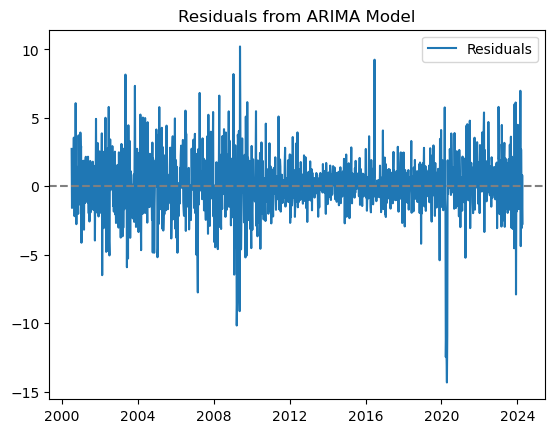

In [18]:
# Calculating residuals
residuals = actual - predictions
residuals = residuals.dropna()
# Plotting the residuals
plt.plot(residuals, label="Residuals")
plt.title("Residuals from ARIMA Model")
plt.axhline(y=0, linestyle="--", color="gray")
plt.legend()
plt.show()

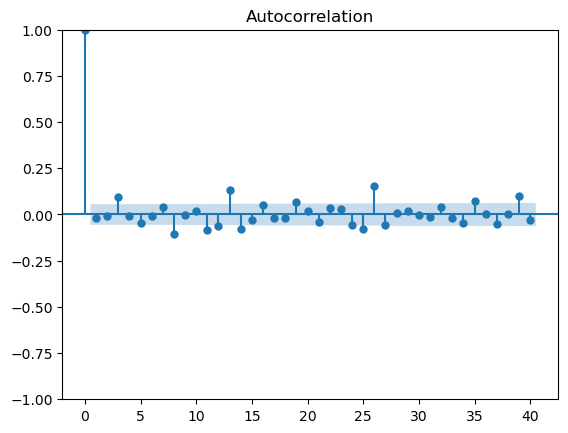

In [19]:
# Plot acf of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

Residuals seem like white noise?


# Trying exogenous variables


In [35]:
"""
Consumer spending
Unemployment
Inflation
Fed funds rate
Average Credit Card APR
"""

retail_sales = fred.get_series("RSXFS")  # Monthly
inflation = fred.get_series("B712RG3Q086SBEA")  # Quarterly
unemployment = fred.get_series("UNRATE")  # Monthly
fedfunds = fred.get_series("FEDFUNDS")  # Monthly
apr = fred.get_series("TERMCBCCALLNS")  # Quarterly